## Lab Web Scraping:  Spotify Song Recommender

# TOC:
* [Web Scraping top 200 list](#first-bullet)
* [Recommend from Top 200 list](#second-bullet)
* [Get Spotify songs data base to recommend from](#third-bullet)
* [Optimum parameters and clustering model](#fourth-bullet)



### Web Scraping top 200 list<a class="anchor" id="first-bullet"></a>

**Import Libraries**

In [54]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import re
import random
from pandas.io.json import json_normalize
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

In [55]:
#attribute url
url = "https://www.popvortex.com/music/charts/top-100-songs.php"

In [56]:
#get request
response = requests.get(url)
response.status_code

200

In [57]:
soup = BeautifulSoup(response.content, "html.parser")

In [58]:
#divide the different criteria into a different lists to be put into our final dataframe
artist = []
song = []
genre = []
year = []

num_iter = len("body > div.container > div:nth-child(4) > div.col-xs-12.col-md-8 > div.chart-wrapper > div.feed-item")

songart = soup.select("body > div.container > div:nth-child(4) > div.col-xs-12.col-md-8 > div.chart-wrapper > div.feed-item")
genlist = soup.select("body > div.container > div:nth-child(4) > div.col-xs-12.col-md-8 > div.chart-wrapper > div.feed-item > div.chart-content")
yearlist = soup.select("body > div.container > div:nth-child(4) > div.col-xs-12.col-md-8 > div.chart-wrapper > div.feed-item > div.chart-content > ul > li:nth-child(2)")

for i in range(num_iter):
    artist.append(songart[i].em.get_text())
    song.append(songart[i].cite.get_text())
    year.append(yearlist[i].get_text())    
    try:
        genre.append(genlist[i].ul.li.a.get_text())
    except:
        genre.append('Unknown')  

In [59]:
#Attribute the lists to a dataframe
top100 = pd.DataFrame({'artist':artist
                    ,'track':song
                    ,'genre':genre
                    ,'year':year})

In [64]:
top100.head(60)

,artist,track,genre,year
0,Lizzo,About Damn Time,Pop,"Release Date: April 14, 2022"
1,Kate Bush,Running Up That Hill (A Deal with God),Pop,"Release Date: August 5, 1985"
2,Chapel Hart,You Can Have Him Jolene,Country,"Release Date: January 23, 2021"
3,FLETCHER,Becky’s So Hot,New Release,Pop
4,Harry Styles,As It Was,Pop,"Release Date: March 31, 2022"
5,Luke Combs,The Kind of Love We Make,Country,"Release Date: June 16, 2022"
6,Walker Hayes,Y'all Life,New Release,Country
7,P!nk,Irrelevant,Pop,"Release Date: July 13, 2022"
8,Beyoncé,BREAK MY SOUL,Pop,"Release Date: June 21, 2022"
9,Slipknot,The Dying Song (Time To Sing),New Release,Heavy Metal


In [65]:
#In the year column we have a Genre: leak. We will split these genres...  
def genresplit(value):
    if 'Genre:' in value:
        name = value.split('Genre: ')[1]
        return name
    else:
        return value

In [66]:
#...move these genres 
top100['genre'] = top100['genre'].apply(genresplit)
top100['year'] = top100['year'].apply(genresplit)

In [67]:
def tidy(value):
    type1 = value['genre']
    type2 = value['year']
    if str(type1) == 'New Release':
        return type2
    else:
        return type1
top100['genre'] = top100.apply(tidy,axis=1)

In [68]:
#finally split the year column by the comma and find the year value. "Nan" values filled with 2022, because it was originally a "New Release" value
top100['year'] = top100['year'].str.split(", ", n = 1, expand = True)[1]
top100['year'] = top100['year'].fillna(2022)
top100['track'] = top100['track'].str.strip()

In [69]:
top100

,artist,track,genre,year
0,Lizzo,About Damn Time,Pop,2022
1,Kate Bush,Running Up That Hill (A Deal with God),Pop,1985
2,Chapel Hart,You Can Have Him Jolene,Country,2021
3,FLETCHER,Becky’s So Hot,Pop,2022
4,Harry Styles,As It Was,Pop,2022
...,...,...,...,...
95,Halsey,So Good,Alternative,2022
96,New Radicals,You Get What You Give,Pop,1998
97,j-hope,= (Equal Sign),K-Pop,2022
98,Doja Cat,Vegas,Soundtrack,2022


Second top 100 list:

In [70]:
urls = "https://spinditty.com/playlists/100songs"

In [71]:
responses = requests.get(urls)
responses.status_code

200

In [74]:
soup2 = BeautifulSoup(responses.content, "html.parser")

In [75]:
##attribute different values to song, artist, genre and year lists. 

songartist2 = []
genre2 = []
years2 = []
num_iter = len("body > div.container > div:nth-child(4) > div.col-xs-12.col-md-8 > div.chart-wrapper > div.feed-item")

songarts = soup2.select("body > phoenix-page > div > div > div.m-page > section > article > div > div > section > div > div > h2")
genres = soup2.select("body > phoenix-page > div > div > div.m-page > section > article > div > div > section > div > div > p")
years = soup2.select("body > phoenix-page > div > div > div.m-page > section > article > div > div > section > div > div > h3")
for i in range(len(songarts)):
    songartist2.append(songarts[i].get_text())
    
for i in range(len(genres)):
    genre2.append(genres[i].get_text())
        
for i in range(len(years)):
    years2.append(years[i].get_text())


In [76]:
##find genre in text.............................
genrefin = []
for i in genre2:
    if 'Genre:' in i:
        genrefin.append(i)
    elif 'GENRE:' in i:
        genrefin.append(i)
##filter any unneeded rows.......................
songartfin = []        
for j in songartist2:
    if '#' in j:
        songartfin.append(j)
##treat values longer than years.................
lap = []
for i in years2:
    if len(i) > 4:
        i = re.findall('\d{4}',i)
        lap.append(i)
    else:
        lap.append(i)
years2 = lap

In [77]:
#drop any duplicates, then create the dataframe for table2 
top100s = pd.DataFrame({'go':songartfin})
top100s = top100s.drop_duplicates().reset_index()
top100s = pd.DataFrame({'go': top100s['go'], 'genre':genrefin, 'year':years2})

In [78]:
top100s

,go,genre,year
0,"#100 - ""Bitter Sweet Symphony"" by The Verve",Genre: Britpop,[1997]
1,"#99: ""For What It's Worth"" by Buffalo Springfield",Genre: Folk Rock,1967
2,"#98 ""Fire and Rain"" by James Taylor",Genre: Folk Rock,[1970]
3,"#97: ""Rolling in the Deep"" by Adele",Genre: Pop,[2011]
4,"#96 ""(We're Gonna) Rock Around the Clock"" by B...",Genre: Rock & Roll,1954
...,...,...,...
95,"#5: ""Stairway to Heaven""",Genre: Rock,[1971]
96,"#4: ""Imagine"" by John Lennon",Genre: Rock,[1971]
97,"#3: ""Like a Rolling Stone"" by Bob Dylan",Genre: Folk Rock,[1965]
98,"#2: ""Yesterday"" by The Beatles",Genre: British Invasion,[1965]


In [79]:
#determine artist, genre and track columns, as well as year cleaning. 
top100s['track'] = top100s['go'].str.split("by", n = 1, expand = True)[0]
top100s['artist'] = top100s['go'].str.split("by", n = 1, expand = True)[1]
top100s['track'] = top100s['track'].str.split('"', n = 1, expand = True)[1]
top100s['genre'] = top100s['genre'].str.split(': ', n = 1, expand = True)[1]
top100s['track'] = top100s['track'].str.replace('"','')
yearconvert = []
#if it's a list:
for i in top100s['year']:
    if isinstance(i,list):
        yearconvert.append(i[0])
    else:
        yearconvert.append(i)
top100s['year'] = yearconvert
top100s['track'] = top100s['track'].str.strip()

In [80]:
top100s = top100s[['track','artist','genre','year']]

In [81]:
top100s

,track,artist,genre,year
0,Bitter Sweet Symphony,The Verve,Britpop,1997
1,For What It's Worth,Buffalo Springfield,Folk Rock,1967
2,Fire and Rain,James Taylor,Folk Rock,1970
3,Rolling in the Deep,Adele,Pop,2011
4,(We're Gonna) Rock Around the Clock,Bill Haley and His Comets,Rock & Roll,1954
...,...,...,...,...
95,Stairway to Heaven,None,Rock,1971
96,Imagine,John Lennon,Rock,1971
97,Like a Rolling Stone,Bob Dylan,Folk Rock,1965
98,Yesterday,The Beatles,British Invasion,1965


In [82]:
#concatenate into one table
top100s = top100s[['track','artist','genre','year']]
top100 = top100[['track','artist','genre','year']]
top = pd.concat([top100,top100s], axis = 0).reset_index()
top = top.drop(columns='index')

In [83]:
top

,track,artist,genre,year
0,About Damn Time,Lizzo,Pop,2022
1,Running Up That Hill (A Deal with God),Kate Bush,Pop,1985
2,You Can Have Him Jolene,Chapel Hart,Country,2021
3,Becky’s So Hot,FLETCHER,Pop,2022
4,As It Was,Harry Styles,Pop,2022
...,...,...,...,...
195,Stairway to Heaven,None,Rock,1971
196,Imagine,John Lennon,Rock,1971
197,Like a Rolling Stone,Bob Dylan,Folk Rock,1965
198,Yesterday,The Beatles,British Invasion,1965


## Recommend from Top 200 list <a class="anchor" id="second-bullet"></a>

In [84]:
def musicrecommender():
    song = input("Name of your song: ")    
    if song in list(top['track']):
        print(top['track'].iloc[random.randint(0,200)])    
    elif song not in list(top['track']):
        print("Sorry, we cannot recommend any songs")

In [85]:
musicrecommender()

Name of your song: Yesterday
Blitzkrieg Bop


## Get Spotify songs data base to recommend from<a class="anchor" id="third-bullet"></a>

Import the spotipy library and access account

In [32]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

In [33]:
secrets_file = open("secrets.txt","r")

In [34]:
string = secrets_file.read()
string.split('\n')

['cid:dc735e5f93a34ef284c10ceabecd270e',
 'csecret:d5b2ce46ac224e3bb0b06504ca5c2c83']

In [35]:
secrets_dict={}
for line in string.split('\n'):
    if len(line) > 0:
        secrets_dict[line.split(':')[0]]=line.split(':')[1]

In [36]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

#InitializeSpotiPy with user credentials
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=secrets_dict['cid'],
                                                           client_secret=secrets_dict['csecret']))

Use Jan's code to get the playlist information. We compiled two lists, as the maximum space that spotify permits is 9999 in one. All together around 13.000 tracks

In [37]:
from random import randint
from time import sleep

def get_playlist_tracks(playlist_id):
    results = sp.user_playlist_tracks("spotify",playlist_id)
    tracks = results['items']
    while results['next']!=None:
        results = sp.next(results)
        tracks = tracks + results['items']
        sleep(randint(1,3))
    return tracks

In [38]:
playlist1 = get_playlist_tracks("6tIxyT1Gq6O7DK7rIEUEZo")
playlist2 = get_playlist_tracks("4pbDDX7np7Q1H0ghL7U9o7")

Here we see that the total songs (with duplicates, probably) is  

In [39]:
print('no. 1    ',len(playlist1))
print('no. 2    ',len(playlist2))
print('total is',len(playlist1)+len(playlist2))

no. 1     9999
no. 2     3878
total is 13877


Create a function to extract all necessary information from the dictionaries (and apply)

In [40]:
def artistsong(pops):
    artist = []
    song = []
    features = []
    counter = 0
    for i in pops:
        song.append(pops[counter]['track']['name'])
        artist.append(pops[counter]['track']['artists'][0]['name'])
        features.append(sp.audio_features(pops[counter]["track"]["uri"]))
        counter += 1
    return pd.DataFrame({'artist': artist, 'song': song, 'features': features})


In [41]:
playlist1df = artistsong(playlist1)

Expected id of type track but found type A%C3%AFcha spotify:local:Khaled:Sahra:A%C3%AFcha:259
Expected id of type track but found type Kids+In+America spotify:local:Kim+Wilde:Simply+The+Best+Of+The+80%27s:Kids+In+America:202
Expected id of type track but found type La+Bamba spotify:local:Los+Lobos:The+Best+Latino+Carnival+In+The+World+...+Ever%21+%28Disc+1%29:La+Bamba:171
Expected id of type track but found type Live+Is+Life spotify:local:Opus:Simply+The+Best+Of+The+80%27s:Live+Is+Life:244
Expected id of type track but found type All+Night+Long spotify:local:Lionel+Richie:Can%27t+Slow+Down:All+Night+Long:379
Expected id of type track but found type %28Keep+Feeling%29+Fascination spotify:local:The+Human+League:Grand+Theft+Auto%3A+Vice+City%2C+Vol.+2%3A+Wave+103:%28Keep+Feeling%29+Fascination:222
Expected id of type track but found type More+Than+This spotify:local:Roxy+Music:Grand+Theft+Auto%3A+Vice+City%2C+Vol.+3%3A+Emotion+98.3:More+Than+This:266
Expected id of type track but found ty

In [42]:
playlist2df = artistsong(playlist2)

Our dataframes look like this. The only problem is that the upis are not unpacked yet. We will deal with that now

In [43]:
playlist1df

,artist,song,features
0,Queen,A Kind Of Magic - Remastered 2011,"[{'danceability': 0.67, 'energy': 0.776, 'key'..."
1,Queen,Bohemian Rhapsody - Remastered 2011,"[{'danceability': 0.414, 'energy': 0.404, 'key..."
2,Queen,Another One Bites The Dust - Remastered 2011,"[{'danceability': 0.933, 'energy': 0.528, 'key..."
3,Queen,Don't Stop Me Now - Remastered 2011,"[{'danceability': 0.559, 'energy': 0.868, 'key..."
4,Queen,Under Pressure - Remastered 2011,"[{'danceability': 0.671, 'energy': 0.712, 'key..."
...,...,...,...
9994,Kip Winger,California - From the Moon to the Sun,"[{'danceability': 0.517, 'energy': 0.444, 'key..."
9995,Kip Winger,What We Are - From the Moon to the Sun,"[{'danceability': 0.476, 'energy': 0.721, 'key..."
9996,Kip Winger,One Big Game - From the Moon to the Sun,"[{'danceability': 0.542, 'energy': 0.7, 'key':..."
9997,Kip Winger,Why - From the Moon to the Sun,"[{'danceability': 0.27, 'energy': 0.561, 'key'..."


In [44]:
playlist2df

,artist,song,features
0,ANGRA,Live and Learn,"[{'danceability': 0.431, 'energy': 0.984, 'key..."
1,ANGRA,Bleeding Heart,"[{'danceability': 0.5, 'energy': 0.545, 'key':..."
2,ANGRA,Hunters and Prey,"[{'danceability': 0.56, 'energy': 0.892, 'key'..."
3,ANGRA,Eyes of Christ,"[{'danceability': 0.512, 'energy': 0.937, 'key..."
4,ANGRA,Rebirth (Acoustic Version),"[{'danceability': 0.348, 'energy': 0.596, 'key..."
...,...,...,...
3873,Fleetwood Mac,Family Man,"[{'danceability': 0.688, 'energy': 0.644, 'key..."
3874,Fleetwood Mac,Welcome To The Room...Sara,"[{'danceability': 0.632, 'energy': 0.555, 'key..."
3875,Fleetwood Mac,Isn't It Midnight,"[{'danceability': 0.469, 'energy': 0.73, 'key'..."
3876,Fleetwood Mac,When I See You Again,"[{'danceability': 0.544, 'energy': 0.0907, 'ke..."


First we normalise using the json_normalize() function, then we apply them to individual columns and convert them to a dataframe.

In [45]:
playlist1df['features'] = json_normalize(playlist1df['features'])
playlist2df['features'] = json_normalize(playlist2df['features'])

/var/folders/sm/8s2c1j894rq6v788yfhxt27r0000gn/T/ipykernel_4014/962824347.py:1: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  playlist1df['features'] = json_normalize(playlist1df['features'])
/var/folders/sm/8s2c1j894rq6v788yfhxt27r0000gn/T/ipykernel_4014/962824347.py:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  playlist2df['features'] = json_normalize(playlist2df['features'])


In [46]:
playlist1features = pd.DataFrame.from_records(playlist1df.features.dropna().tolist())
playlist2features = pd.DataFrame.from_records(playlist2df.features.dropna().tolist())

We concat these dataframes and drop our features column (it has now been unpacked) 

In [47]:
playlist1df = playlist1df.reset_index(drop = True)
playlist1features = playlist1features.reset_index(drop = True)
playlist_db1 = pd.concat([playlist1df,playlist1features], axis = 1)
playlist_db1 = playlist_db1.drop(columns = 'features')
playlist_db1 

,artist,song,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,Queen,A Kind Of Magic - Remastered 2011,0.670,0.776,9.0,-5.874,1.0,0.0356,0.0184,0.002940,0.1280,0.703,130.128,audio_features,5RYLa5P4qweEAKq5U1gdcK,spotify:track:5RYLa5P4qweEAKq5U1gdcK,https://api.spotify.com/v1/tracks/5RYLa5P4qweE...,https://api.spotify.com/v1/audio-analysis/5RYL...,264253.0,4.0
1,Queen,Bohemian Rhapsody - Remastered 2011,0.414,0.404,0.0,-9.928,0.0,0.0499,0.2710,0.000000,0.3000,0.224,71.105,audio_features,4u7EnebtmKWzUH433cf5Qv,spotify:track:4u7EnebtmKWzUH433cf5Qv,https://api.spotify.com/v1/tracks/4u7EnebtmKWz...,https://api.spotify.com/v1/audio-analysis/4u7E...,354320.0,4.0
2,Queen,Another One Bites The Dust - Remastered 2011,0.933,0.528,5.0,-6.472,0.0,0.1610,0.1120,0.312000,0.1630,0.754,109.967,audio_features,5vdp5UmvTsnMEMESIF2Ym7,spotify:track:5vdp5UmvTsnMEMESIF2Ym7,https://api.spotify.com/v1/tracks/5vdp5UmvTsnM...,https://api.spotify.com/v1/audio-analysis/5vdp...,214653.0,4.0
3,Queen,Don't Stop Me Now - Remastered 2011,0.559,0.868,5.0,-5.276,1.0,0.1700,0.0475,0.000176,0.7760,0.609,156.295,audio_features,5T8EDUDqKcs6OSOwEsfqG7,spotify:track:5T8EDUDqKcs6OSOwEsfqG7,https://api.spotify.com/v1/tracks/5T8EDUDqKcs6...,https://api.spotify.com/v1/audio-analysis/5T8E...,209413.0,4.0
4,Queen,Under Pressure - Remastered 2011,0.671,0.712,2.0,-7.815,1.0,0.0476,0.4290,0.000000,0.1030,0.462,113.805,audio_features,2fuCquhmrzHpu5xcA1ci9x,spotify:track:2fuCquhmrzHpu5xcA1ci9x,https://api.spotify.com/v1/tracks/2fuCquhmrzHp...,https://api.spotify.com/v1/audio-analysis/2fuC...,248440.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,Kip Winger,California - From the Moon to the Sun,0.517,0.444,0.0,-12.046,0.0,0.0267,0.5550,0.000940,0.1320,0.216,187.950,audio_features,2STE3vIHHIgz9TNB5aJGC1,spotify:track:2STE3vIHHIgz9TNB5aJGC1,https://api.spotify.com/v1/tracks/2STE3vIHHIgz...,https://api.spotify.com/v1/audio-analysis/2STE...,239396.0,4.0
9995,Kip Winger,What We Are - From the Moon to the Sun,0.476,0.721,0.0,-7.143,1.0,0.0335,0.1000,0.000122,0.4070,0.470,86.987,audio_features,3pQJKvK6hmVPzDXRv67PCo,spotify:track:3pQJKvK6hmVPzDXRv67PCo,https://api.spotify.com/v1/tracks/3pQJKvK6hmVP...,https://api.spotify.com/v1/audio-analysis/3pQJ...,210223.0,4.0
9996,Kip Winger,One Big Game - From the Moon to the Sun,0.542,0.700,5.0,-7.395,0.0,0.0359,0.0669,0.006750,0.0850,0.403,153.999,audio_features,03P0IMmk5nXRyrhh0YpTfc,spotify:track:03P0IMmk5nXRyrhh0YpTfc,https://api.spotify.com/v1/tracks/03P0IMmk5nXR...,https://api.spotify.com/v1/audio-analysis/03P0...,226416.0,4.0
9997,Kip Winger,Why - From the Moon to the Sun,0.270,0.561,2.0,-8.061,0.0,0.0351,0.5370,0.000640,0.1970,0.151,140.047,audio_features,70Hf4cnE286JKpi3lwRb1w,spotify:track:70Hf4cnE286JKpi3lwRb1w,https://api.spotify.com/v1/tracks/70Hf4cnE286J...,https://api.spotify.com/v1/audio-analysis/70Hf...,402891.0,4.0


In [48]:
playlist2df = playlist2df.reset_index(drop = True)
playlist2features = playlist2features.reset_index(drop = True)
playlist_db2 = pd.concat([playlist2df,playlist2features], axis = 1)
playlist_db2 = playlist_db2.drop(columns = 'features')
playlist_db2

,artist,song,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,ANGRA,Live and Learn,0.431,0.9840,1,-5.131,1,0.0907,0.00591,0.000003,0.0650,0.167,144.996,audio_features,5LZci9wxIwwvF9qh8cMpHS,spotify:track:5LZci9wxIwwvF9qh8cMpHS,https://api.spotify.com/v1/tracks/5LZci9wxIwwv...,https://api.spotify.com/v1/audio-analysis/5LZc...,254293,4
1,ANGRA,Bleeding Heart,0.500,0.5450,10,-7.115,1,0.0277,0.16500,0.000000,0.3670,0.118,123.974,audio_features,4m2HvlrZ1kKsgFpcLh5h0V,spotify:track:4m2HvlrZ1kKsgFpcLh5h0V,https://api.spotify.com/v1/tracks/4m2HvlrZ1kKs...,https://api.spotify.com/v1/audio-analysis/4m2H...,246053,4
2,ANGRA,Hunters and Prey,0.560,0.8920,2,-6.740,1,0.0366,0.00286,0.002030,0.1020,0.679,114.986,audio_features,3Gs5F9IN5BEhU8jhdr5KrQ,spotify:track:3Gs5F9IN5BEhU8jhdr5KrQ,https://api.spotify.com/v1/tracks/3Gs5F9IN5BEh...,https://api.spotify.com/v1/audio-analysis/3Gs5...,391280,4
3,ANGRA,Eyes of Christ,0.512,0.9370,8,-5.403,1,0.0467,0.06220,0.000003,0.0792,0.469,105.021,audio_features,2ahYaznOR2pfAu6voMj3T7,spotify:track:2ahYaznOR2pfAu6voMj3T7,https://api.spotify.com/v1/tracks/2ahYaznOR2pf...,https://api.spotify.com/v1/audio-analysis/2ahY...,257973,4
4,ANGRA,Rebirth (Acoustic Version),0.348,0.5960,9,-7.498,0,0.0291,0.50100,0.000000,0.1110,0.343,74.179,audio_features,3tQWuqbfcQumQL3KHfOM3C,spotify:track:3tQWuqbfcQumQL3KHfOM3C,https://api.spotify.com/v1/tracks/3tQWuqbfcQum...,https://api.spotify.com/v1/audio-analysis/3tQW...,217533,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3873,Fleetwood Mac,Family Man,0.688,0.6440,7,-12.733,1,0.0360,0.02070,0.007750,0.1070,0.918,123.350,audio_features,7FaarqLNsZlFsRMQjjX5QR,spotify:track:7FaarqLNsZlFsRMQjjX5QR,https://api.spotify.com/v1/tracks/7FaarqLNsZlF...,https://api.spotify.com/v1/audio-analysis/7Faa...,247440,4
3874,Fleetwood Mac,Welcome To The Room...Sara,0.632,0.5550,7,-13.081,0,0.0409,0.11400,0.000003,0.2600,0.732,99.064,audio_features,5H1EXMKjBFlI5F9QkCD6Ft,spotify:track:5H1EXMKjBFlI5F9QkCD6Ft,https://api.spotify.com/v1/tracks/5H1EXMKjBFlI...,https://api.spotify.com/v1/audio-analysis/5H1E...,222840,4
3875,Fleetwood Mac,Isn't It Midnight,0.469,0.7300,0,-11.890,0,0.0358,0.00264,0.048200,0.1500,0.573,145.781,audio_features,2icOTC7sCLZSDVbCPJ6olG,spotify:track:2icOTC7sCLZSDVbCPJ6olG,https://api.spotify.com/v1/tracks/2icOTC7sCLZS...,https://api.spotify.com/v1/audio-analysis/2icO...,253760,4
3876,Fleetwood Mac,When I See You Again,0.544,0.0907,11,-20.015,0,0.0268,0.87200,0.000000,0.1030,0.103,79.789,audio_features,0QE9gbtUuiSJIqclW9N2TQ,spotify:track:0QE9gbtUuiSJIqclW9N2TQ,https://api.spotify.com/v1/tracks/0QE9gbtUuiSJ...,https://api.spotify.com/v1/audio-analysis/0QE9...,229493,4


Now we concat to create our final dataframe with over 12500 songs

In [381]:
playlist_db1 = playlist_db1.reset_index(drop = True)
playlist_db2 = playlist_db2.reset_index(drop = True)
final_p = pd.concat([playlist_db1,playlist_db2], axis = 0)
final_p = final_p.drop_duplicates()
final_p = final_p.reset_index(drop = True)
final_p

,artist,song,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,Queen,A Kind Of Magic - Remastered 2011,0.670,0.7760,9.0,-5.874,1.0,0.0356,0.01840,0.002940,0.1280,0.703,130.128,audio_features,5RYLa5P4qweEAKq5U1gdcK,spotify:track:5RYLa5P4qweEAKq5U1gdcK,https://api.spotify.com/v1/tracks/5RYLa5P4qweE...,https://api.spotify.com/v1/audio-analysis/5RYL...,264253.0,4.0
1,Queen,Bohemian Rhapsody - Remastered 2011,0.414,0.4040,0.0,-9.928,0.0,0.0499,0.27100,0.000000,0.3000,0.224,71.105,audio_features,4u7EnebtmKWzUH433cf5Qv,spotify:track:4u7EnebtmKWzUH433cf5Qv,https://api.spotify.com/v1/tracks/4u7EnebtmKWz...,https://api.spotify.com/v1/audio-analysis/4u7E...,354320.0,4.0
2,Queen,Another One Bites The Dust - Remastered 2011,0.933,0.5280,5.0,-6.472,0.0,0.1610,0.11200,0.312000,0.1630,0.754,109.967,audio_features,5vdp5UmvTsnMEMESIF2Ym7,spotify:track:5vdp5UmvTsnMEMESIF2Ym7,https://api.spotify.com/v1/tracks/5vdp5UmvTsnM...,https://api.spotify.com/v1/audio-analysis/5vdp...,214653.0,4.0
3,Queen,Don't Stop Me Now - Remastered 2011,0.559,0.8680,5.0,-5.276,1.0,0.1700,0.04750,0.000176,0.7760,0.609,156.295,audio_features,5T8EDUDqKcs6OSOwEsfqG7,spotify:track:5T8EDUDqKcs6OSOwEsfqG7,https://api.spotify.com/v1/tracks/5T8EDUDqKcs6...,https://api.spotify.com/v1/audio-analysis/5T8E...,209413.0,4.0
4,Queen,Under Pressure - Remastered 2011,0.671,0.7120,2.0,-7.815,1.0,0.0476,0.42900,0.000000,0.1030,0.462,113.805,audio_features,2fuCquhmrzHpu5xcA1ci9x,spotify:track:2fuCquhmrzHpu5xcA1ci9x,https://api.spotify.com/v1/tracks/2fuCquhmrzHp...,https://api.spotify.com/v1/audio-analysis/2fuC...,248440.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12603,Fleetwood Mac,Mystified,0.533,0.2510,3.0,-18.749,1.0,0.0275,0.73100,0.173000,0.0917,0.582,177.957,audio_features,4CtNKBje5C6aOPW0pStdY9,spotify:track:4CtNKBje5C6aOPW0pStdY9,https://api.spotify.com/v1/tracks/4CtNKBje5C6a...,https://api.spotify.com/v1/audio-analysis/4CtN...,190200.0,4.0
12604,Fleetwood Mac,Welcome To The Room...Sara,0.632,0.5550,7.0,-13.081,0.0,0.0409,0.11400,0.000003,0.2600,0.732,99.064,audio_features,5H1EXMKjBFlI5F9QkCD6Ft,spotify:track:5H1EXMKjBFlI5F9QkCD6Ft,https://api.spotify.com/v1/tracks/5H1EXMKjBFlI...,https://api.spotify.com/v1/audio-analysis/5H1E...,222840.0,4.0
12605,Fleetwood Mac,Isn't It Midnight,0.469,0.7300,0.0,-11.890,0.0,0.0358,0.00264,0.048200,0.1500,0.573,145.781,audio_features,2icOTC7sCLZSDVbCPJ6olG,spotify:track:2icOTC7sCLZSDVbCPJ6olG,https://api.spotify.com/v1/tracks/2icOTC7sCLZS...,https://api.spotify.com/v1/audio-analysis/2icO...,253760.0,4.0
12606,Fleetwood Mac,When I See You Again,0.544,0.0907,11.0,-20.015,0.0,0.0268,0.87200,0.000000,0.1030,0.103,79.789,audio_features,0QE9gbtUuiSJIqclW9N2TQ,spotify:track:0QE9gbtUuiSJIqclW9N2TQ,https://api.spotify.com/v1/tracks/0QE9gbtUuiSJ...,https://api.spotify.com/v1/audio-analysis/0QE9...,229493.0,4.0


In [324]:
#final_p.to_csv('song_recommender_playlist.csv', index = False)

In [86]:
final_p = pd.read_csv('songs_list_df.csv')

## Optimum parameters and clustering model<a class="anchor" id="fourth-bullet"></a>

In [87]:
final_p

,artist,song,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,Queen,A Kind Of Magic - Remastered 2011,0.670,0.7760,9.0,-5.874,1.0,0.0356,0.01840,0.002940,0.1280,0.703,130.128,audio_features,5RYLa5P4qweEAKq5U1gdcK,spotify:track:5RYLa5P4qweEAKq5U1gdcK,https://api.spotify.com/v1/tracks/5RYLa5P4qweE...,https://api.spotify.com/v1/audio-analysis/5RYL...,264253.0,4.0
1,Queen,Bohemian Rhapsody - Remastered 2011,0.414,0.4040,0.0,-9.928,0.0,0.0499,0.27100,0.000000,0.3000,0.224,71.105,audio_features,4u7EnebtmKWzUH433cf5Qv,spotify:track:4u7EnebtmKWzUH433cf5Qv,https://api.spotify.com/v1/tracks/4u7EnebtmKWz...,https://api.spotify.com/v1/audio-analysis/4u7E...,354320.0,4.0
2,Queen,Another One Bites The Dust - Remastered 2011,0.933,0.5280,5.0,-6.472,0.0,0.1610,0.11200,0.312000,0.1630,0.754,109.967,audio_features,5vdp5UmvTsnMEMESIF2Ym7,spotify:track:5vdp5UmvTsnMEMESIF2Ym7,https://api.spotify.com/v1/tracks/5vdp5UmvTsnM...,https://api.spotify.com/v1/audio-analysis/5vdp...,214653.0,4.0
3,Queen,Don't Stop Me Now - Remastered 2011,0.559,0.8680,5.0,-5.276,1.0,0.1700,0.04750,0.000176,0.7760,0.609,156.295,audio_features,5T8EDUDqKcs6OSOwEsfqG7,spotify:track:5T8EDUDqKcs6OSOwEsfqG7,https://api.spotify.com/v1/tracks/5T8EDUDqKcs6...,https://api.spotify.com/v1/audio-analysis/5T8E...,209413.0,4.0
4,Queen,Under Pressure - Remastered 2011,0.671,0.7120,2.0,-7.815,1.0,0.0476,0.42900,0.000000,0.1030,0.462,113.805,audio_features,2fuCquhmrzHpu5xcA1ci9x,spotify:track:2fuCquhmrzHpu5xcA1ci9x,https://api.spotify.com/v1/tracks/2fuCquhmrzHp...,https://api.spotify.com/v1/audio-analysis/2fuC...,248440.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12603,Fleetwood Mac,Mystified,0.533,0.2510,3.0,-18.749,1.0,0.0275,0.73100,0.173000,0.0917,0.582,177.957,audio_features,4CtNKBje5C6aOPW0pStdY9,spotify:track:4CtNKBje5C6aOPW0pStdY9,https://api.spotify.com/v1/tracks/4CtNKBje5C6a...,https://api.spotify.com/v1/audio-analysis/4CtN...,190200.0,4.0
12604,Fleetwood Mac,Welcome To The Room...Sara,0.632,0.5550,7.0,-13.081,0.0,0.0409,0.11400,0.000003,0.2600,0.732,99.064,audio_features,5H1EXMKjBFlI5F9QkCD6Ft,spotify:track:5H1EXMKjBFlI5F9QkCD6Ft,https://api.spotify.com/v1/tracks/5H1EXMKjBFlI...,https://api.spotify.com/v1/audio-analysis/5H1E...,222840.0,4.0
12605,Fleetwood Mac,Isn't It Midnight,0.469,0.7300,0.0,-11.890,0.0,0.0358,0.00264,0.048200,0.1500,0.573,145.781,audio_features,2icOTC7sCLZSDVbCPJ6olG,spotify:track:2icOTC7sCLZSDVbCPJ6olG,https://api.spotify.com/v1/tracks/2icOTC7sCLZS...,https://api.spotify.com/v1/audio-analysis/2icO...,253760.0,4.0
12606,Fleetwood Mac,When I See You Again,0.544,0.0907,11.0,-20.015,0.0,0.0268,0.87200,0.000000,0.1030,0.103,79.789,audio_features,0QE9gbtUuiSJIqclW9N2TQ,spotify:track:0QE9gbtUuiSJIqclW9N2TQ,https://api.spotify.com/v1/tracks/0QE9gbtUuiSJ...,https://api.spotify.com/v1/audio-analysis/0QE9...,229493.0,4.0


In [88]:
#drop columns that dont have any relevant info, contain urls, or other categorical irrelevant data
final_p = final_p.drop(columns= ["type","track_href","analysis_url", 'key', 'id', 'uri', 'duration_ms','mode', 'time_signature'], axis=1)
final_p = final_p.dropna(subset = ['danceability', 'artist']) #drop NaNs in danceability (12 songs)nand artist (1)
final_p

,artist,song,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,Queen,A Kind Of Magic - Remastered 2011,0.670,0.7760,-5.874,0.0356,0.01840,0.002940,0.1280,0.703,130.128
1,Queen,Bohemian Rhapsody - Remastered 2011,0.414,0.4040,-9.928,0.0499,0.27100,0.000000,0.3000,0.224,71.105
2,Queen,Another One Bites The Dust - Remastered 2011,0.933,0.5280,-6.472,0.1610,0.11200,0.312000,0.1630,0.754,109.967
3,Queen,Don't Stop Me Now - Remastered 2011,0.559,0.8680,-5.276,0.1700,0.04750,0.000176,0.7760,0.609,156.295
4,Queen,Under Pressure - Remastered 2011,0.671,0.7120,-7.815,0.0476,0.42900,0.000000,0.1030,0.462,113.805
...,...,...,...,...,...,...,...,...,...,...,...
12603,Fleetwood Mac,Mystified,0.533,0.2510,-18.749,0.0275,0.73100,0.173000,0.0917,0.582,177.957
12604,Fleetwood Mac,Welcome To The Room...Sara,0.632,0.5550,-13.081,0.0409,0.11400,0.000003,0.2600,0.732,99.064
12605,Fleetwood Mac,Isn't It Midnight,0.469,0.7300,-11.890,0.0358,0.00264,0.048200,0.1500,0.573,145.781
12606,Fleetwood Mac,When I See You Again,0.544,0.0907,-20.015,0.0268,0.87200,0.000000,0.1030,0.103,79.789


**Get numericals:**

In [89]:
X = final_p.select_dtypes(include=np.number)
y = final_p['song']

In [90]:
X

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.670,0.7760,-5.874,0.0356,0.01840,0.002940,0.1280,0.703,130.128
1,0.414,0.4040,-9.928,0.0499,0.27100,0.000000,0.3000,0.224,71.105
2,0.933,0.5280,-6.472,0.1610,0.11200,0.312000,0.1630,0.754,109.967
3,0.559,0.8680,-5.276,0.1700,0.04750,0.000176,0.7760,0.609,156.295
4,0.671,0.7120,-7.815,0.0476,0.42900,0.000000,0.1030,0.462,113.805
...,...,...,...,...,...,...,...,...,...
12603,0.533,0.2510,-18.749,0.0275,0.73100,0.173000,0.0917,0.582,177.957
12604,0.632,0.5550,-13.081,0.0409,0.11400,0.000003,0.2600,0.732,99.064
12605,0.469,0.7300,-11.890,0.0358,0.00264,0.048200,0.1500,0.573,145.781
12606,0.544,0.0907,-20.015,0.0268,0.87200,0.000000,0.1030,0.103,79.789


**Scaling:**

In [91]:
X_prep = StandardScaler().fit_transform(X)

In [92]:
pd.DataFrame(X_prep,columns=X.columns).head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.799831,0.389792,0.580265,-0.441994,-0.751430,-0.444341,-0.428415,0.807232,0.320009
1,-0.729553,-1.199113,-0.488768,-0.263079,0.127655,-0.455816,0.601773,-1.111861,-1.776086
2,2.371035,-0.669478,0.422573,1.126955,-0.425688,0.761949,-0.218784,1.011562,-0.395973
3,0.136700,0.782747,0.737956,1.239559,-0.650157,-0.455129,3.452758,0.430625,1.249282
4,0.805806,0.116432,0.068426,-0.291856,0.677518,-0.455816,-0.578152,-0.158324,-0.259673


**Seeing Which clusters work best:**

In [93]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=11, random_state=1234)
kmeans.fit(X_prep)

KMeans(n_clusters=11, random_state=1234)

In [94]:
# Predicting / assigning the clusters:
clusters = kmeans.predict(X_prep)

# Check the size of the clusters
pd.Series(clusters).value_counts().sort_index()

0      370
1      675
2     1267
3     2334
4     1032
5       57
6     1530
7     1909
8     1425
9      456
10    1540
dtype: int64

In [95]:
clusters

array([ 3, 10,  8, ...,  6,  2,  8], dtype=int32)

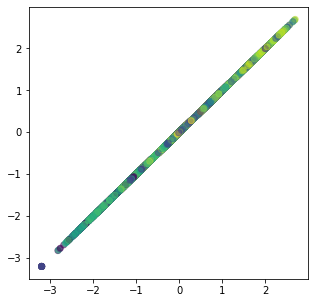

0 0


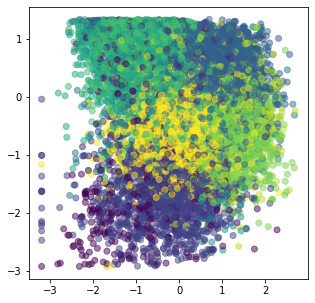

0 1


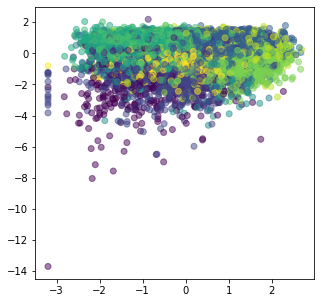

0 2


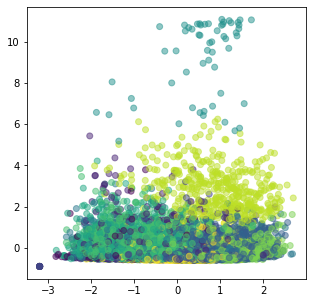

0 3


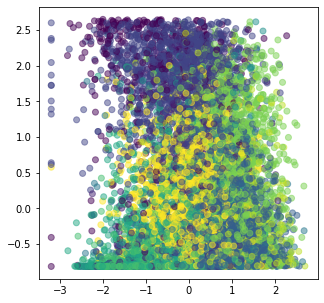

0 4


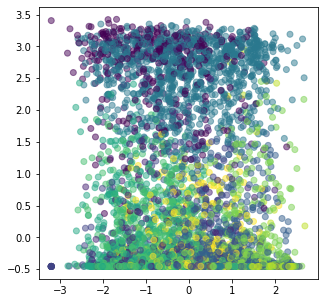

0 5


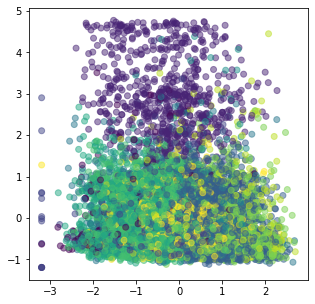

0 6


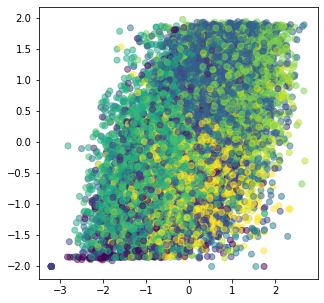

0 7


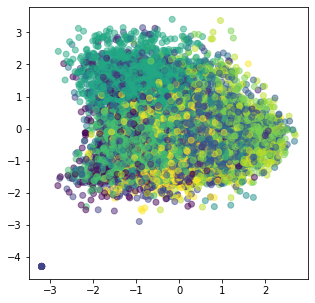

0 8


IndexError: index 9 is out of bounds for axis 1 with size 9

<Figure size 360x360 with 0 Axes>

In [96]:
#loop through col names to plot pairs of features and see which ones show clear clusters 
for i in range(13):
    for j in range(13):
        plt.figure(figsize=(5, 5))
        plt.scatter(X_prep[:, i], X_prep[:, j],  c= clusters, alpha=0.5)
        plt.show()
        print(i,j)

This is one of the few where we vaguely see some grouping, but still not clear:

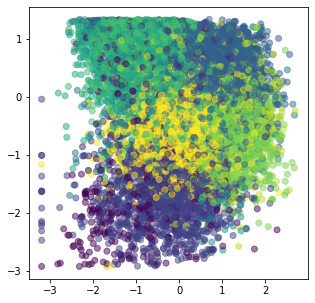

In [97]:
plt.figure(figsize=(5, 5))
plt.scatter(X_prep[:, 0], X_prep[:, 1], c=clusters,alpha=0.5)
plt.show()

Text(0.5, 1.0, 'Elbow Method showing the optimal k')

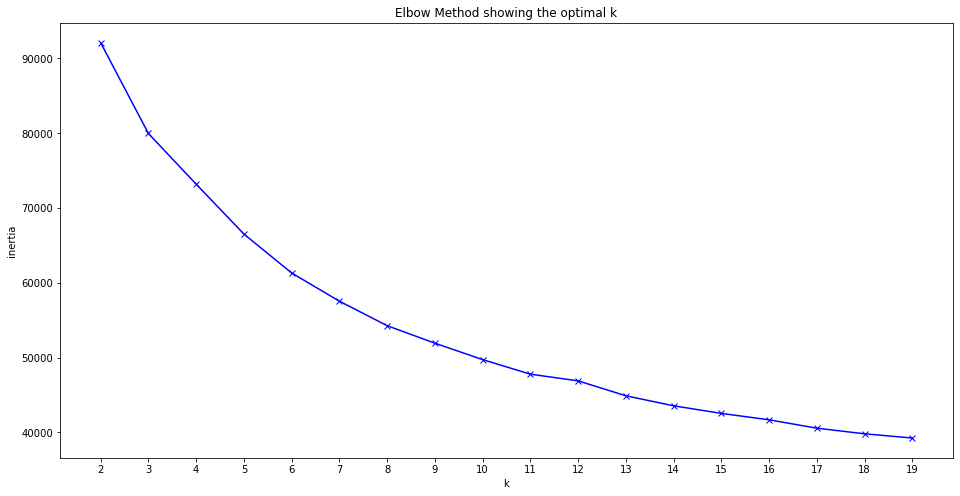

In [98]:
K = range(2,20)
inertia = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(X_prep)
    inertia.append(kmeans.inertia_)

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

We could argue here if is 6 , 8 ,11or 13. We think 6 iss a very low number of clusters in order to have more different clusters so the recomendation has more list to 'fit' the given song

Text(0.5, 1.0, 'Silhouette score showing the optimal k')

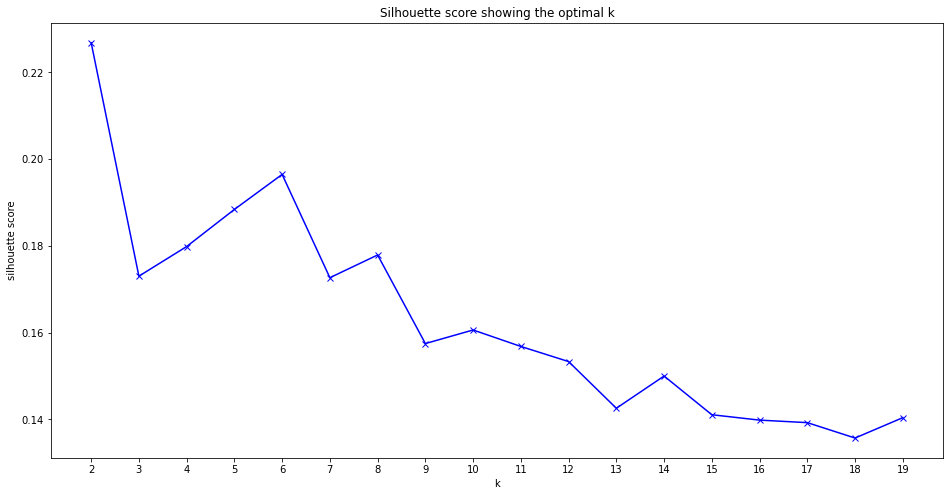

In [99]:
K = range(2,20)
silhouette = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=1234)
    kmeans.fit(X_prep)
    silhouette.append(silhouette_score(X_prep, kmeans.predict(X_prep)))
    
plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Silhouette score showing the optimal k')

**Difficult to see clusters so we run a PCA test**

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=59)

In [101]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [102]:
X_train

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
1078,0.739,0.679,-5.079,0.0373,0.000424,0.018700,0.389,0.786,127.487
4495,0.759,0.563,-8.643,0.0338,0.699000,0.619000,0.144,0.860,136.670
10332,0.853,0.827,-6.165,0.2820,0.114000,0.000000,0.290,0.582,131.967
6918,0.468,0.971,-5.289,0.1370,0.030300,0.000070,0.265,0.457,112.882
4838,0.585,0.213,-13.667,0.0442,0.608000,0.000009,0.106,0.321,142.627
...,...,...,...,...,...,...,...,...,...
6352,0.366,0.976,-4.538,0.0895,0.000182,0.000008,0.158,0.181,149.987
9592,0.358,0.628,-9.685,0.0556,0.005860,0.471000,0.111,0.262,108.441
664,0.812,0.855,-9.117,0.1060,0.340000,0.085700,0.127,0.479,118.013
7599,0.495,0.677,-6.139,0.0271,0.269000,0.000000,0.381,0.437,84.879


In [103]:
pca = PCA()
pca.fit(X_train_scaled)

PCA()

In [104]:
pca.explained_variance_ratio_.round(2)

array([0.27, 0.18, 0.12, 0.11, 0.11, 0.1 , 0.05, 0.05, 0.02])

Individual and cummulative Explained Variance 

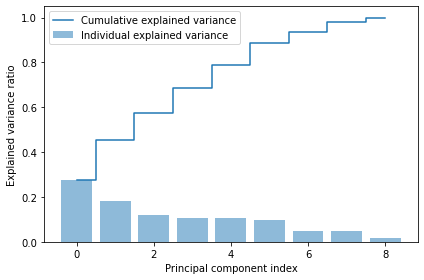

In [105]:
exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

plt.bar(range(0,len(exp_var_pca)), exp_var_pca, 
        alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, 
         where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

PCA shows around 7 components will give us over 90% of the occurrences

In [106]:
pca = PCA(7)
pca.fit(X_train_scaled)

PCA(n_components=7)

In [107]:
pca.explained_variance_ratio_.sum()

0.9357596200768932

Now let's run the Kmeans m odel with 7 clusters 

In [108]:
kmeans = KMeans(n_clusters=7, random_state=1234)
kmeans.fit(X_prep)

KMeans(n_clusters=7, random_state=1234)

And apply the Kmean model to the data, to predict / assign clusters 

In [43]:
clusters = kmeans.predict(X_prep)
pd.Series(clusters).value_counts().sort_index()

0     338
1     730
2    2148
3    3516
4    1143
5    2882
6    1838
dtype: int64

In [109]:
clusters

array([ 3, 10,  8, ...,  6,  2,  8], dtype=int32)

In [110]:
%%time
kmeans = KMeans(n_clusters=4,
                init="random",
                n_init=100,  # try with 1, 4, 8, 20, 30, 100...
                max_iter=10,
                tol=0,
                random_state=1234)
kmeans.fit(X_prep)
print(kmeans.inertia_)

73195.62236516569
CPU times: user 2.73 s, sys: 148 ms, total: 2.87 s
Wall time: 1.04 s


We create a columnn with the cluster to which each song belongs:

In [111]:
final_p['cluster'] = clusters

Now we are going to visually inspect if the clusters have grouped songs in a way that makes sense, meaning we dint have opera with heavy metal 

In [49]:
final_p[final_p['cluster'] == 2].head(60)

,artist,song,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,cluster
1,Queen,Bohemian Rhapsody - Remastered 2011,0.414,0.404,-9.928,0.0499,0.27100,0.000000,0.3000,0.2240,71.105,2
5,Queen,We Will Rock You - Remastered 2011,0.692,0.497,-7.316,0.1190,0.67600,0.000000,0.2590,0.4750,81.308,2
11,Queen,Love Of My Life - Remastered 2011,0.329,0.179,-11.589,0.0299,0.93300,0.000005,0.1150,0.2550,154.175,2
14,Queen,Good Old-Fashioned Lover Boy - Remastered 2011,0.543,0.461,-6.724,0.0302,0.57700,0.000000,0.0563,0.3850,96.803,2
21,Queen,Too Much Love Will Kill You - Remastered 2011,0.385,0.395,-7.602,0.0313,0.58000,0.000063,0.1590,0.2100,72.933,2
24,Queen,Who Wants To Live Forever - Remastered 2011,0.182,0.388,-8.672,0.0324,0.54400,0.001340,0.1140,0.0392,139.276,2
35,Queen,Heaven For Everyone - Remastered 2011,0.593,0.425,-9.775,0.0288,0.29000,0.000001,0.1670,0.2680,110.208,2
54,Chris Stapleton,Tennessee Whiskey,0.387,0.375,-10.852,0.0355,0.20500,0.006470,0.0807,0.5030,50.454,2
66,The Band,The Night They Drove Old Dixie Down - Remaster...,0.507,0.493,-8.786,0.0327,0.45300,0.000000,0.2410,0.4670,127.671,2
77,Led Zeppelin,I Can't Quit You Baby - Remaster,0.529,0.452,-12.593,0.1360,0.53400,0.000151,0.3010,0.5390,78.196,2


In [50]:
final_p[final_p['cluster'] == 3].head(60)

,artist,song,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,cluster
0,Queen,A Kind Of Magic - Remastered 2011,0.670,0.776,-5.874,0.0356,0.018400,0.002940,0.1280,0.703,130.128,3
2,Queen,Another One Bites The Dust - Remastered 2011,0.933,0.528,-6.472,0.1610,0.112000,0.312000,0.1630,0.754,109.967,3
4,Queen,Under Pressure - Remastered 2011,0.671,0.712,-7.815,0.0476,0.429000,0.000000,0.1030,0.462,113.805,3
6,Queen,Crazy Little Thing Called Love - Remastered 2011,0.599,0.761,-6.887,0.0421,0.713000,0.000005,0.3490,0.712,77.015,3
7,Queen,Radio Ga Ga - Remastered 2011,0.744,0.502,-7.719,0.0359,0.183000,0.000228,0.1890,0.660,112.344,3
8,Queen,I Want To Break Free - Single Remix,0.795,0.435,-8.927,0.0324,0.084100,0.000260,0.0763,0.596,108.950,3
12,Queen,Killer Queen - Remastered 2011,0.535,0.651,-6.326,0.0544,0.391000,0.000000,0.1330,0.612,117.218,3
26,Queen,Cool Cat - Remastered 2011,0.818,0.400,-9.927,0.1100,0.302000,0.002410,0.1800,0.838,73.760,3
41,Queen,The Invisible Man - Remastered 2011,0.704,0.792,-6.940,0.0422,0.188000,0.015500,0.3280,0.563,119.994,3
51,Larry Heard,Dreaming Of Better Days,0.708,0.688,-13.666,0.0336,0.009000,0.000010,0.2270,0.891,117.988,3


In [51]:
final_p[final_p['cluster'] == 5].head(60)

,artist,song,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,cluster
9,Queen,We Are The Champions - Remastered 2011,0.268,0.459,-6.940,0.0346,0.378000,0.000000,0.1180,0.1750,64.177,5
10,Queen,Somebody To Love - Remastered 2011,0.406,0.698,-7.024,0.0624,0.186000,0.000000,0.2330,0.3330,109.266,5
15,Queen,The Show Must Go On - Remastered 2011,0.426,0.687,-6.926,0.0329,0.409000,0.000000,0.1120,0.1890,84.141,5
16,Queen,You're My Best Friend - Remastered 2011,0.510,0.760,-6.995,0.0411,0.148000,0.011600,0.0706,0.5500,118.829,5
17,Queen,I Want It All - Single Version,0.406,0.847,-5.705,0.0482,0.024900,0.000003,0.3750,0.3790,92.245,5
18,Queen,Fat Bottomed Girls - Remastered 2011,0.337,0.684,-7.674,0.0495,0.031900,0.000007,0.3420,0.4040,88.772,5
20,Queen,Hammer To Fall - Remastered 2011,0.428,0.787,-4.998,0.0849,0.315000,0.000020,0.1240,0.5230,128.582,5
22,Queen,Bicycle Race - Remastered 2011,0.463,0.671,-6.438,0.0683,0.062600,0.000000,0.0947,0.6330,84.280,5
25,Queen,Friends Will Be Friends - Remastered 2011,0.447,0.531,-7.721,0.0269,0.037700,0.000013,0.3360,0.3390,75.051,5
27,Queen,Seven Seas Of Rhye - Remastered 2011,0.317,0.896,-6.089,0.1040,0.122000,0.016800,0.2530,0.4210,126.894,5


In [52]:
final_p[final_p['cluster'] == 1].head(60)

,artist,song,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,cluster
3,Queen,Don't Stop Me Now - Remastered 2011,0.559,0.868,-5.276,0.1700,0.047500,0.000176,0.776,0.6090,156.295,1
19,Queen,Radio Ga Ga - Live Aid,0.406,0.934,-6.668,0.0845,0.013800,0.000000,0.955,0.3950,118.823,1
23,Queen,We Are The Champions - Live Aid,0.316,0.860,-5.038,0.0661,0.175000,0.000049,0.902,0.1950,100.888,1
30,Queen,Keep Yourself Alive - Live At The Rainbow,0.308,0.975,-5.894,0.1730,0.019400,0.000009,0.975,0.2950,138.974,1
34,Queen,Ay-Oh - Live Aid,0.215,0.870,-10.920,0.3510,0.881000,0.112000,0.976,0.4620,144.877,1
45,George Michael,Somebody to Love,0.333,0.863,-6.918,0.0515,0.051800,0.000000,0.972,0.3840,110.162,1
74,The Black Keys,Tighten Up,0.459,0.708,-6.167,0.0681,0.001420,0.000004,0.485,0.5830,108.952,1
84,Elbow,Grounds for Divorce,0.526,0.756,-5.083,0.0266,0.400000,0.000002,0.426,0.6680,91.985,1
86,Tom Petty and the Heartbreakers,Runnin' Down A Dream,0.438,0.966,-6.103,0.0445,0.000442,0.463000,0.691,0.7130,169.798,1
106,The Heavy,Turn Up,0.533,0.907,-2.500,0.1230,0.023000,0.000060,0.617,0.5120,142.098,1


In [112]:
!git add .


In [114]:
!git commit -m'clustering'

[master 886de4e] clustering
 5 files changed, 32909 insertions(+), 700234 deletions(-)
 rewrite .ipynb_checkpoints/Song_Recommender-checkpoint.ipynb (96%)
 create mode 100644 .ipynb_checkpoints/Untitled-checkpoint.ipynb
 rewrite Song_Recommender.ipynb (96%)
 create mode 100644 Untitled.ipynb
 create mode 100644 songs_list_df.csv


In [ ]:
!git push

Enumerating objects: 12, done.
Counting objects: 100% (11/11), done.
Delta compression using up to 4 threads
Compressing objects: 100% (8/8), done.
Writing objects: 100% (8/8), 2.10 MiB | 372.00 KiB/s, done.
Total 8 (delta 3), reused 0 (delta 0), pack-reused 0
